**машина Больцмана: ассоциативная память**

Евгений Борисов <esborisov@sevsu.ru>

---

## библиотеки

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
# import imageio
import pickle
import gzip

from time import time

In [2]:
def plot_images(A,figsize=(10,4)):
    f, axarr = plt.subplots(1,len(A), sharey=False, sharex=False, figsize=figsize)
    for i in range(len(A)): 
        axarr[i].axis('off')
        axarr[i].imshow(A[i])

##  загружаем данные 

In [3]:
# with gzip.open('data/pix/30x30-123/data.pkl.gz','rb') as f: data = pickle.load(f)
# with gzip.open('data/pix/30x30-abc/data.pkl.gz','rb') as f: data = pickle.load(f)
# with gzip.open('data/pix/17x31-123/data.pkl.gz','rb') as f: data = pickle.load(f)

with gzip.open('../data/pix/17x31.pkl.gz','rb') as f: data = pickle.load(f)


In [4]:
ideal = data[0]
test = data[1:]
#n_test = len(data)-1

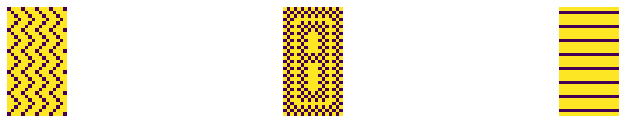

In [5]:
# учебный набор
plot_images(ideal,figsize=(14,2))

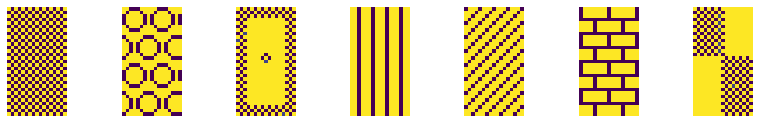

In [6]:
# тестовый набор
for i in range(len(test)): plot_images(test[i],figsize=(14,2))

In [7]:
im_size = ideal[0].shape
im_size

(31, 17)

## загружаем память сети

![boltzman](http://mechanoid.su/content/neural-net-hopfield-associative-memory.html/hopfield.bmp)

In [8]:
# масштабруем в [-1,+1]
X_train = np.vstack([ (m.flatten()>0)*2-1 for m in ideal ])
# добавляем сдвиг
X_train = np.hstack( [ X_train,np.ones([X_train.shape[0],1]),] )

In [9]:
W = X_train.T.dot(X_train)
n = W.shape[0]
# удаляем обратную связь нейрона на самого себя (обнуляем главную диагональ матрицы весов)
W = W *(np.ones([n,n])-np.eye(n,n))

In [10]:
 #np.abs(np.triu(W)-np.tril(W).T).sum()

---

In [11]:
# инициализация генератора псевдослучайных чисел
rng.seed(seed= int(((time()%1)/(time()//1))*1e11) )

энергия сети

$E = - \left( s\cdot W \right) * s - s*\theta $   

$\cdot$ - матричное умножение  
$*$ - поэлементное умножение   
$s$ - состояние сети   
$W$ - матрица весов   
$\theta$ - вектор сдвигов  

In [12]:
def energy(s,W): return -s.dot(W)*s -s*W[:,-1]

генерируем случайное состояние r

и считаем изменение энергии сети

$dE = E(r) - E(s)$

если $dE_i\leq 0$   
то $s_i:=r_i$  
иначе принимаем $s_i:=r_i$ c вероятностью $p_i$

In [13]:
def run(x,W,max_iter=50):
    t0 = t = 100.0 # начальная "температура" сети    
    s = x.copy()
    for i in range(max_iter):
        r = rng.randint(0,2,len(s))*2-1 # случайное состояние
        r[-1] = 1 # сдвиг

        dE = energy(r,W) - energy(s,W) # изменение энергии нейронов

        p = 1.0-1.0/(1.0+np.exp(-dE/t)) # вероятности переходов в новое состояние

        if np.any(np.isnan(p)): break

        ps = p.sum()
        p = p/ps if ps>0 else p

        s_prev = s.copy() # сохряняем старое значение 

        dEc = dE>0 # условие: изменение энергии нейрона > 0

        # если изменение энергии меньше нуля 
        # то принимаем новое состояние нейрона
        s[~dEc] = r[~dEc]

        # если изменение энергии больше нуля 
        # то принимаем новое состояние нейрона с вероятностью p
        m = rng.rand((dEc).sum()) <= p[dEc]
        s[dEc] = r[dEc]*m + s[dEc]*(~m)

        t = t0/(1.0+np.log(i+1.0)) 

        if np.all(s==s_prev): break
        
        # print('%i: t=%.2f, new=%i, [dE<0]:%i'%(i, t, int(nn), (~dEc).sum(),) )
        #nn = np.abs(s_prev-s).sum() # количество нейронов изменивших состояние
        #if nn < 1: break
            
    print(i)
    return s


## тестируем

In [14]:
def make_test(tt,figsize=(20,2)):
    # масштабруем в [-1,+1]
    X_test = np.vstack([(m.flatten()>0)*2-1 for m in tt])
    # добавляем сдвиг
    X_test = np.hstack( [ X_test,np.ones([X_test.shape[0],1]),] )

    # выполняем для всех тестовых примеров
    out = [ run(X_test[i,:],W) for i in range(X_test.shape[0]) ]
    out = [ ((o+1.0)*0.5*255.0).astype(np.uint8)[:-1].reshape(im_size) for o in out ]
    
    f,axarr = plt.subplots(2,len(tt),sharey=False,sharex=False,figsize=figsize)
    for i in range(len(tt)):
        axarr[0,i].imshow( tt[i] )
        axarr[0,i].axis('off')
        axarr[1,i].imshow( out[i])
        axarr[1,i].axis('off')


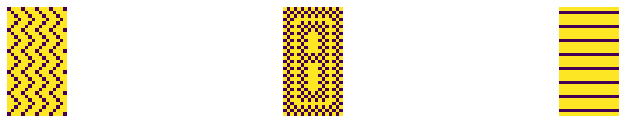

In [15]:
# содержимое памяти сети
plot_images(ideal,figsize=(14,2))

6
8
6
7
6
13
6


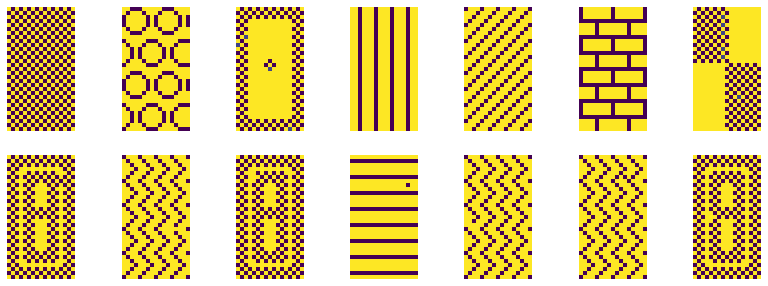

In [16]:
# пары образов: вход,результат(ассоциация)
for i in range(len(test)): make_test(test[i],figsize=(14,5))